In [1]:
import numpy as np
from basis_expansions import (Binner, Polynomial, 
                              LinearSpline, CubicSpline,
                              NaturalCubicSpline)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
x = np.random.uniform(size=100)

def signal(x):
    return (x*x*x*(x-1) 
            + 2*(1/(1 + np.exp(-0.5*(x - 0.5)))) 
            - 3.5*(x > 0.2)*(x < 0.5)*(x - 0.2)*(x - 0.5)
            - 0.95)

y = signal(x) + np.random.normal(scale=0.05, size=100)

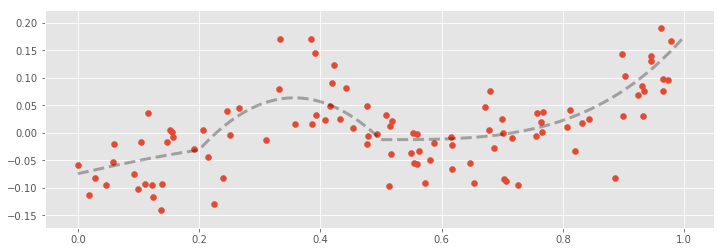

In [3]:
fig, ax = plt.subplots(figsize=(12, 4))
t = np.linspace(0, 1, num=250)

ax.scatter(x, y)
ax.plot(t, signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.3)

# Binned regression with dummy varaibles.

In [4]:
def make_binned_regression(n_cuts):
    return Pipeline([
        ('binner', Binner(0, 1, n_cuts=n_cuts)),
        ('regression', LinearRegression(fit_intercept=False))
    ])

regressions = {}
for n_cuts in range(1, 24):
    regressions[n_cuts] = make_binned_regression(n_cuts)
    regressions[n_cuts].fit(x, y)

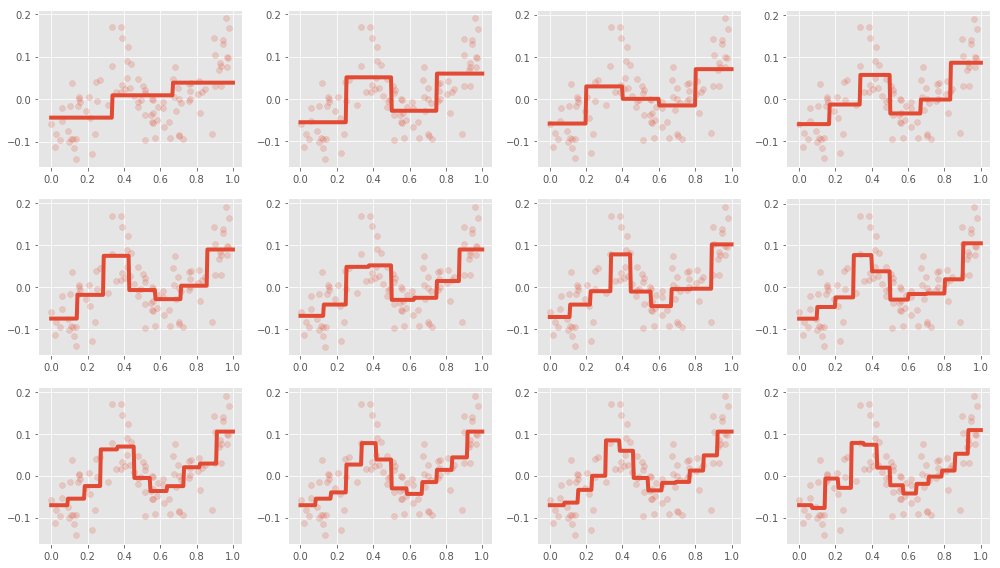

In [5]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8))

t = np.linspace(0, 1, 250)
for n_cuts, ax in enumerate(ax.flatten(), start=2):
    ax.plot(t, regressions[n_cuts].predict(t), linewidth=4)
    ax.scatter(x, y, alpha=0.2)
    
fig.tight_layout()

# Regression with polynomial expansion

In [6]:
def make_polynomial_regression(degree):
    return Pipeline([
        ('std', StandardScaler()),
        ('poly', Polynomial(degree=degree)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for degree in range(1, 24):
    regressions[degree] = make_polynomial_regression(degree)
    regressions[degree].fit(x.reshape(-1, 1), y)

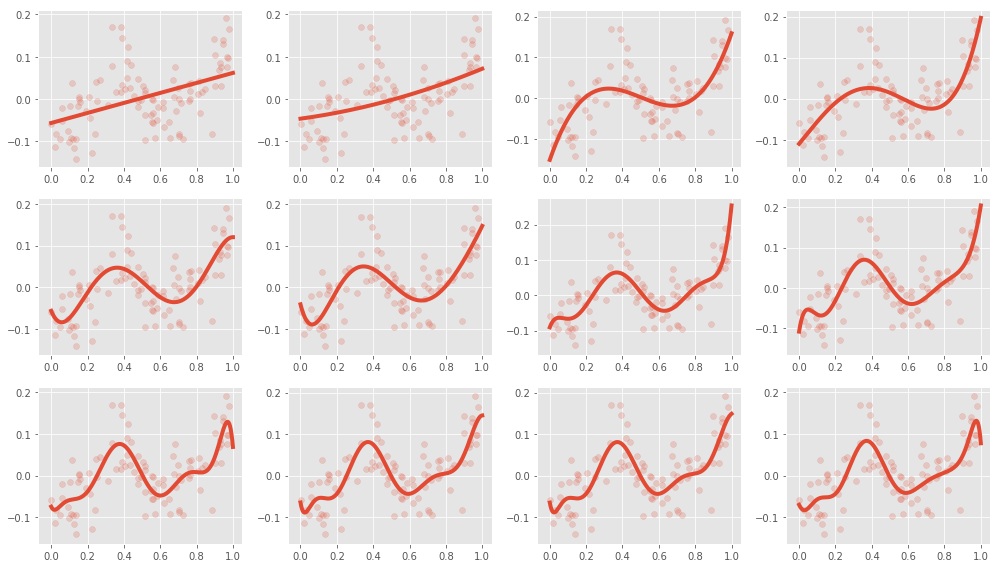

In [7]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    degree = i + 1
    ax.plot(t, regressions[degree].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.2)
    
fig.tight_layout()

# Regression with piecewise linear expansion

In [8]:
def make_pl_regression(n_knots):
    return Pipeline([
        ('pl', LinearSpline(0, 1, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for n_knots in range(2, 25):
    regressions[n_knots] = make_pl_regression(n_knots)
    regressions[n_knots].fit(x.reshape(-1, 1), y)

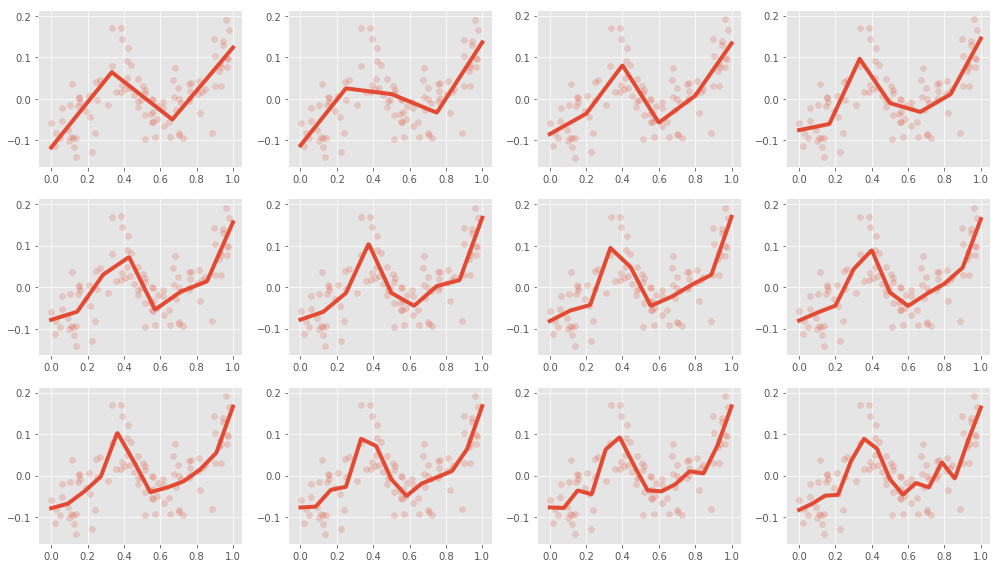

In [9]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    n_knots = i + 2
    ax.plot(t, regressions[n_knots].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.2)
    
fig.tight_layout()

# Regression with piecewise cubic expansion

In [10]:
def make_pw_cubic_regression(n_knots):
    return Pipeline([
        ('pw_cubic', CubicSpline(0, 1, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for n_knots in range(2, 25):
    regressions[n_knots] = make_pw_cubic_regression(n_knots)
    regressions[n_knots].fit(x.reshape(-1, 1), y)

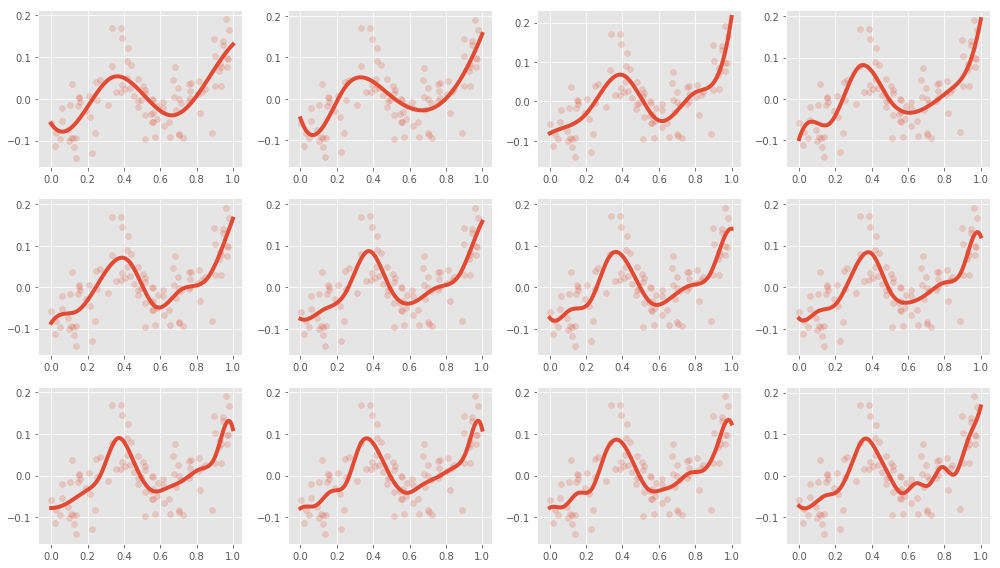

In [11]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    n_knots = i + 2
    ax.plot(t, regressions[n_knots].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.2)
    
fig.tight_layout()

# Regression with piecewise natural cubic expansion

In [12]:
def make_natural_cubic_regression(n_knots):
    return Pipeline([
        ('nat_cubic', NaturalCubicSpline(0, 1, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for n_knots in range(2, 25):
    regressions[n_knots] = make_natural_cubic_regression(n_knots)
    regressions[n_knots].fit(x.reshape(-1, 1), y)

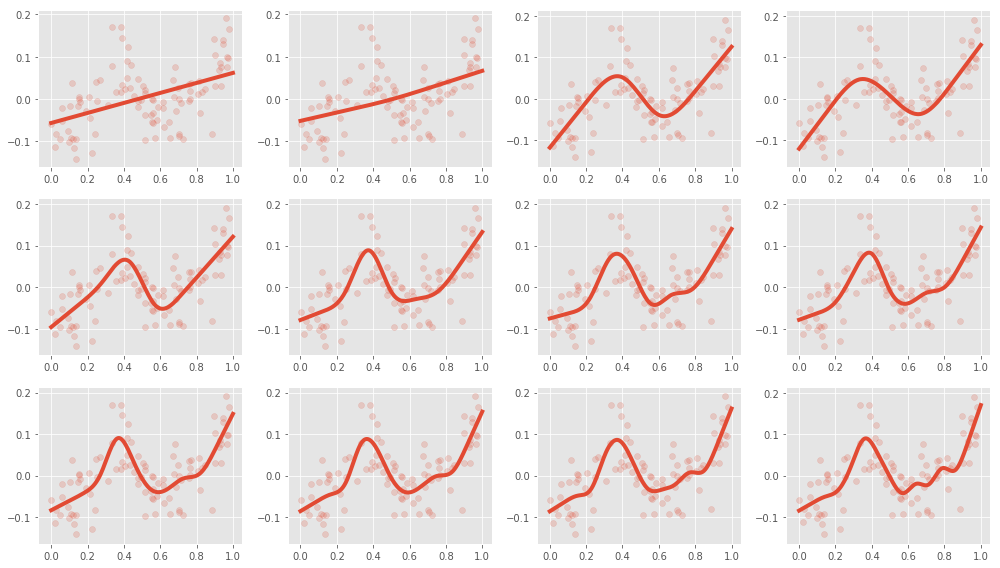

In [13]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    n_knots = i + 2
    ax.plot(t, regressions[n_knots].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.2)
    
fig.tight_layout()

## Examples of all

In [14]:
regressions = [
    {'model': make_binned_regression(5), 
         'title': "Binning Expansion, 6 Bins"},
    
    {'model': make_polynomial_regression(6) , 
         'title': "Polynomial Regression, Degree 6"},
    
    {'model': make_pl_regression(6), 
          'title': "Linear Spline, 6 Knots"},

    {'model': make_pw_cubic_regression(6) , 
         'title': "Cubic Spline, 6 Knots"},

    {'model': make_natural_cubic_regression(6), 
         'title': "Natural Cubic Spline, 6 Knots"}
]

for reg in regressions:
    reg['model'].fit(x.reshape(-1, 1), y)

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


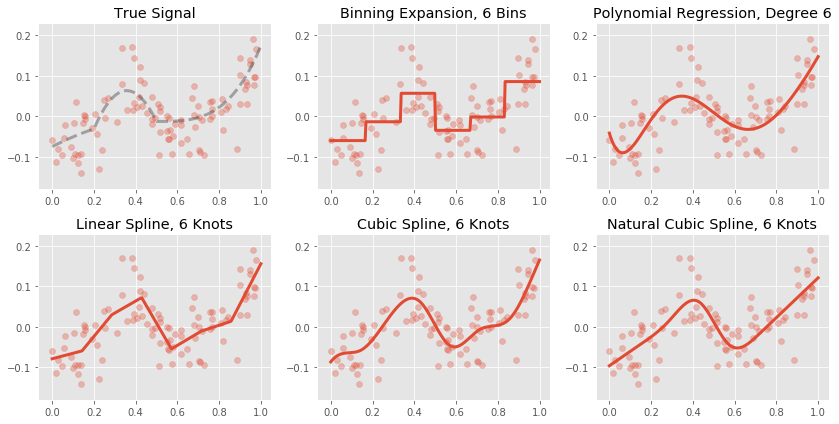

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

axs[0, 0].scatter(x, y, alpha=0.33)
axs[0, 0].plot(t, signal(t), linewidth=3, linestyle="--", 
               color="black", alpha=0.3)
axs[0, 0].set_title("True Signal")

for i, ax in enumerate(axs.flatten()[1:]):
    ax.scatter(x, y, alpha=0.33)
    ax.plot(t, regressions[i]['model'].predict(t), linewidth=3)
    ax.set_title(regressions[i]['title'])
    
fig.tight_layout()

## Examples Applying to Series, Creating Data Frames

In [16]:
s = pd.Series([1, 2, 3, 4, 5, 6], name='s', index=['a', 'b', 'c', 'd', 'e', 'f'])

In [17]:
df = pd.DataFrame([[1, 2], [2, 3]], columns=['x', 'y'])

In [18]:
s.index

Index(['a', 'b', 'c', 'd', 'e', 'f'], dtype='object')

In [19]:
binner = Binner(cutpoints=[2, 4])
binner.fit_transform(s)

,s_bin_neg_infinity_to_2,s_bin_2_to_4,s_bin_4_to_pos_infinity
a,1.0,0.0,0.0
b,1.0,0.0,0.0
c,0.0,1.0,0.0
d,0.0,1.0,0.0
e,0.0,0.0,1.0
f,0.0,0.0,1.0


In [20]:
np.array([True, True, False]) & np.array([False, True, True])

array([False,  True, False], dtype=bool)

## Investigating Performance with Different Smoothers

In [41]:
def make_random_train_test(signal, N=250):
    x_train = np.random.uniform(0, 1, size=N)
    y_train = signal(x_train) + np.random.normal(scale=0.1, size=N)
    x_test = np.random.uniform(0, 1, size=N)
    y_test = signal(x_test) + np.random.normal(scale=0.1, size=N)
    return (x_train, y_train), (x_test, y_test)

In [45]:
def run_trials(signal, regressors, N=250, N_trials=250):
    N_dof = len(degrees_of_freedom)
    train_errors = np.empty(shape=(N_trials, N_dof))
    test_errors = np.empty(shape=(N_trials, N_dof))
    for i in range(N_trials):
        for j, regressor in enumerate(regressors):
            (x, y), (x_test, y_test) = make_random_train_test(signal, N)
            regressor.fit(x.reshape(-1, 1), y)
            y_hat_train, y_hat_test = (regressor.predict(x.reshape(-1, 1)), 
                                       regressor.predict(x_test.reshape(-1, 1)))
            train_error, test_error = (np.mean((y - y_hat_train)**2), 
                                       np.mean((y_test - y_hat_test)**2))
            train_errors[i, j] = train_error
            test_errors[i, j] = test_error
    return train_errors, test_errors

def run_simulation_expreiment(signal, regressors, N=250, N_trials=250):
    trials = run_trials(signal, regressors, N, N_trials)
    
    def make_mean_errors(trials):
        train_mean_errors = trials[0].mean(axis=0)
        test_mean_errors = trials[1].mean(axis=0)
        return train_mean_errors, test_mean_errors
    
    def make_standard_errors(trials):
        train_standard_errors = trials[0].std(axis=0)
        test_standard_errors = trials[1].std(axis=0)
        return train_standard_errors, test_standard_errors
    
    mean_errors = make_mean_errors(trials)
    standard_errors = make_standard_errors(trials)
    return mean_errors, standard_errors

In [42]:
def linear_signal(x):
    return x

def sin_signal(x):
    return np.sin(2*np.pi*x)

def weird_signal(x):
    return (x*x*x*(x-1) 
            + 2*(1/(1 + np.exp(-0.5*(x - 0.5)))) 
            - 3.5*(x > 0.2)*(x < 0.5)*(x - 0.2)*(x - 0.5)
            - 0.95)

In [31]:
degrees_of_freedom = list(range(2, 40))

def make_binned_regression(n_params):
    return Pipeline([
        ('binner', Binner(0, 1, n_params=n_params)),
        ('regression', LinearRegression(fit_intercept=False))
    ])

def make_polynomial_regression(n_params):
    return Pipeline([
        ('std', StandardScaler()),
        ('poly', Polynomial(n_params=n_params)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

def make_pl_regression(n_params):
    return Pipeline([
        ('pl', LinearSpline(0, 1, n_params=n_params)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

def make_natural_cubic_regression(n_params):
    return Pipeline([
        ('nat_cubic', NaturalCubicSpline(0, 1, n_params=n_params)),
        ('regression', LinearRegression(fit_intercept=True))
    ])


def make_non_linear_regressions(regression_maker, degrees_of_freedom):
    return [regression_maker(dof) for dof in degrees_of_freedom]

binned_regressors = make_non_linear_regressions(make_binned_regression,
                                                degrees_of_freedom)
polynomial_regressors = make_non_linear_regressions(make_polynomial_regression,
                                                    degrees_of_freedom)
pl_regressors = make_non_linear_regressions(make_pl_regression,
                                            degrees_of_freedom)
ncs_regressors = make_non_linear_regressions(make_natural_cubic_regression,
                                             degrees_of_freedom)

In [74]:
#binned_trials = run_trials(binned_regressors)
#polynomial_trials = run_trials(polynomial_regressors)
#pl_trials = run_trials(pl_regressors)
#ncs_trials = run_trials(ncs_regressors)

#binned_mean_errors = make_mean_errors(binned_trials)
#polynomial_mean_errors = make_mean_errors(polynomial_trials)
#pl_mean_errors = make_mean_errors(pl_trials)
#ncs_mean_errors = make_mean_errors(ncs_trials)

#binned_mean_errors, binned_std_errors = run_simulation_expreiment(
#    linear_signal, binned_regressors)
#polynomial_mean_errors, polynomial_std_errors = run_simulation_expreiment(
#    linear_signal, polynomial_regressors)
#pl_mean_errors, pl_std_errors = run_simulation_expreiment(
#    linear_signal, pl_regressors)
ncs_mean_errors, ncs_std_errors = run_simulation_expreiment(
    linear_signal, ncs_regressors)

In [59]:
def plot_simulation_expreiment(ax, mean_errors, std_errors):
    train_me, test_me = mean_errors
    train_se, test_se = std_errors
    train_top_band, train_bottom_band = train_me + train_se, train_me - train_se
    test_top_band, test_bottom_band = test_me + test_se, test_me - test_se

    ax.plot(degrees_of_freedom, train_me, label="Train")
    ax.fill_between(
        degrees_of_freedom, train_top_band, train_bottom_band, alpha=0.2)
    ax.plot(degrees_of_freedom, test_me, label="Test")
    ax.fill_between(
        degrees_of_freedom, test_top_band, test_bottom_band, alpha=0.2)
    ax.legend()

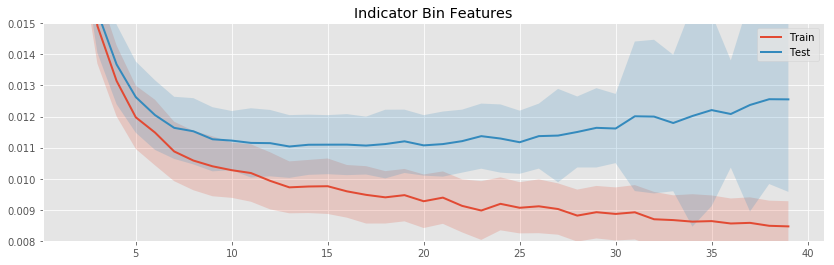

In [71]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax, binned_mean_errors, binned_std_errors)
ax.set_ylim(0.008, 0.015)
ax.set_title("Indicator Bin Features")

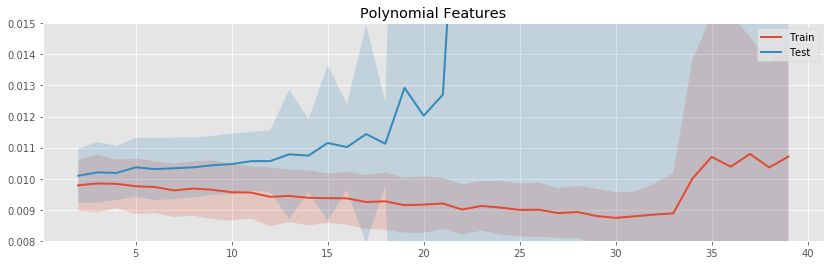

In [72]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax, polynomial_mean_errors, polynomial_std_errors)
ax.set_ylim(0.008, 0.015)
ax.set_title("Polynomial Features")

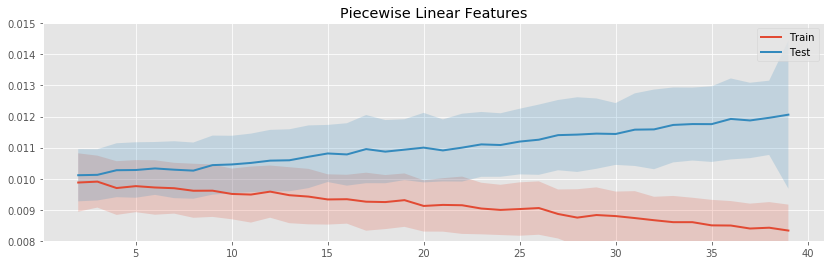

In [73]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax, pl_mean_errors, pl_std_errors)
ax.set_ylim(0.008, 0.015)
ax.set_title("Piecewise Linear Features")

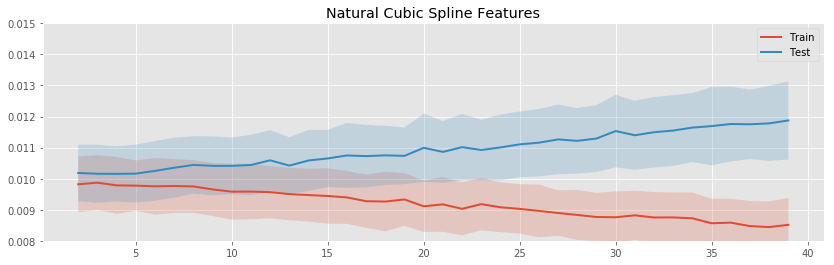

In [75]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax, ncs_mean_errors, ncs_std_errors)
ax.set_ylim(0.008, 0.015)
ax.set_title("Natural Cubic Spline Features")